### Import

In [ ]:
import sys, os
os.chdir(os.path.abspath(os.path.join(os.getcwd(), '..')))
project_root = os.getcwd()
if project_root not in sys.path: sys.path.append(project_root)

import torch
import lightning
import numpy as np
import pandas as pd

import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import src


device = "cuda"

### Pretrain

In [2]:
# config
config_load_path = "config/pretrain.json"
with open(config_load_path, "r") as f: config = json.load(f)
config["data"]["batch_size"] = 256
# datamodule
datamodule = src.data.DataModule(**config["data"])
datamodule.setup()
# model
ckpt = torch.load("ckpt/pretrain/epoch=731-step=32940.ckpt", weights_only=True)
model = src.model.SCOST(**config["model"])
state_dict = {
    k.replace("model.", ""): v for k, v in ckpt["state_dict"].items()
    if k.startswith("model.")
}
model.load_state_dict(state_dict, strict=False)
model = model.to(device)
model.eval()

SCOST(
  (embedding): Embedding(
    (embd_token): EmbeddingToken(
      (te): Linear(in_features=20, out_features=256, bias=True)
    )
    (embd_channel): EmbeddingChannel(
      (ce): Embedding(8, 256)
    )
    (embd_position): EmbeddingPosition()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
      

In [3]:
loss_train: torch.Tensor = None     # type: ignore
for batch in datamodule.train_dataloader():
    with torch.no_grad():
        batch = [item.to(device) for item in batch]
        x, channel_idx, _ = batch
        x, y = model(x, channel_idx, mask=False, task="reconstruction")
        loss_b = torch.nn.functional.l1_loss(x, y, reduction="none")
        loss_b = loss_b.sum(dim=(0)).cpu() / x.shape[0]
        if loss_train is None: loss_train = loss_b
        else: loss_train += loss_b
loss_train /= len(datamodule.train_dataloader())
loss_val: torch.Tensor = None       # type: ignore
for batch in datamodule.val_dataloader():
    with torch.no_grad():
        batch = [item.to(device) for item in batch]
        x, channel_idx, _ = batch
        x, y = model(x, channel_idx, mask=False, task="reconstruction")
        loss_b = torch.nn.functional.l1_loss(x, y, reduction="none")
        loss_b = loss_b.sum(dim=(0)).cpu() / x.shape[0]
        if loss_val is None: loss_val = loss_b
        else: loss_val += loss_b
loss_val /= len(datamodule.val_dataloader())
loss_test: torch.Tensor = None      # type: ignore
for batch in datamodule.test_dataloader():
    with torch.no_grad():
        batch = [item.to(device) for item in batch]
        x, channel_idx, _ = batch
        x, y = model(x, channel_idx, mask=False, task="reconstruction")
        loss_b = torch.nn.functional.l1_loss(x, y, reduction="none")
        loss_b = loss_b.sum(dim=(0)).cpu() / x.shape[0]
        if loss_test is None: loss_test = loss_b
        else: loss_test += loss_b
loss_test /= len(datamodule.test_dataloader())

            train     val    test
channel_1  0.0097  0.0086  0.0087
channel_2  0.0097  0.0106  0.0107
channel_3  0.0097  0.0100  0.0102


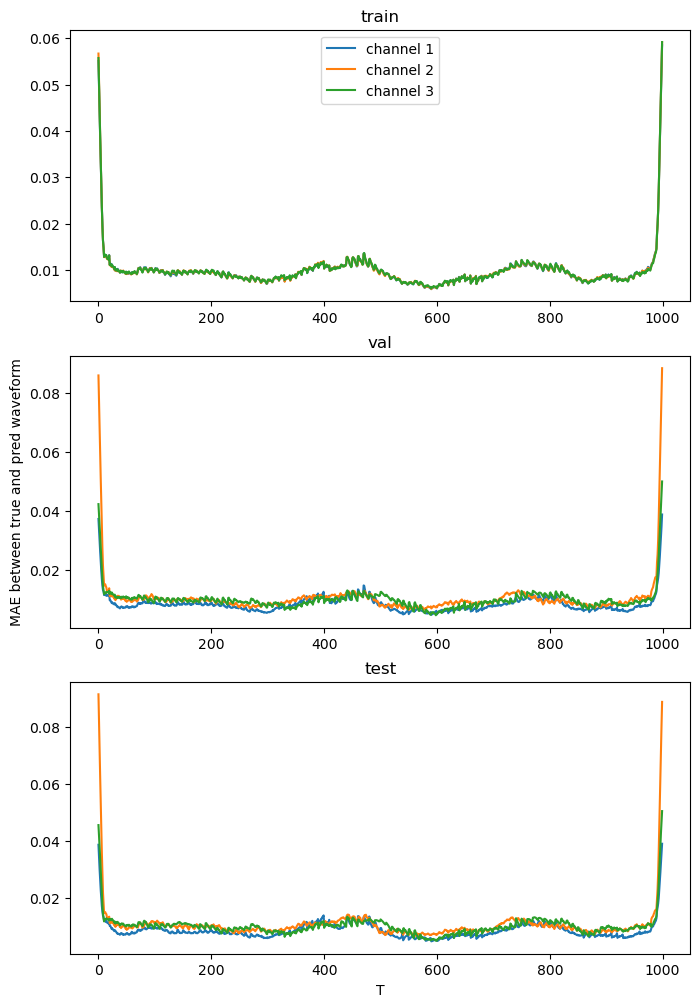

In [4]:
loss_train_mean = loss_train.sum(dim=1) / loss_train.shape[1]
loss_val_mean = loss_val.sum(dim=1) / loss_val.shape[1]
loss_test_mean = loss_test.sum(dim=1) / loss_test.shape[1]
# print as a table
df = pd.DataFrame({
    "train": loss_train_mean.numpy(),
    "val": loss_val_mean.numpy(),
    "test": loss_test_mean.numpy(),
}, index=[f"channel_{i+1}" for i in range(loss_train.shape[0])])
print(df.round(4))

plt.figure(figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.plot(loss_train[0], label="channel 1")
plt.plot(loss_train[1], label="channel 2")
plt.plot(loss_train[2], label="channel 3")
plt.title("train")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(loss_val[0], label="channel 1")
plt.plot(loss_val[1], label="channel 2")
plt.plot(loss_val[2], label="channel 3")
plt.title("val")
plt.ylabel("MAE between true and pred waveform")
plt.subplot(3, 1, 3)
plt.plot(loss_test[0], label="channel 1")
plt.plot(loss_test[1], label="channel 2")
plt.plot(loss_test[2], label="channel 3")
plt.title("test")
plt.xlabel("T")
plt.show()

            train     val    test
channel_1  0.0092  0.0082  0.0083
channel_2  0.0092  0.0097  0.0098
channel_3  0.0092  0.0096  0.0097


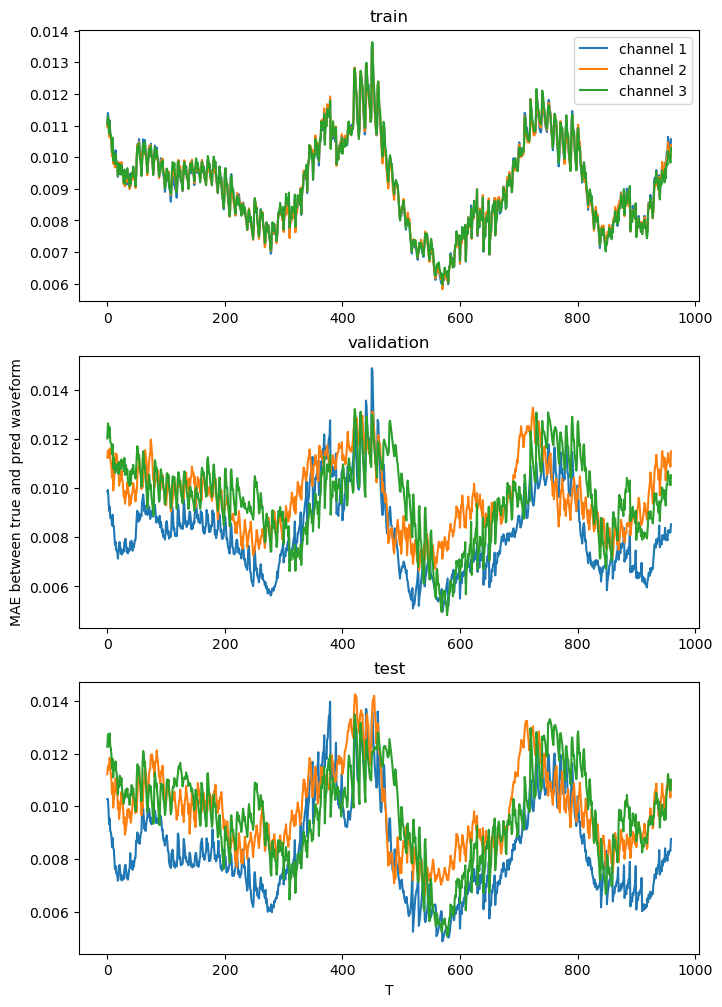

In [5]:
loss_train_mean = loss_train[:, 20:980].sum(dim=1) / loss_train[:, 20:980].shape[1]
loss_val_mean = loss_val[:, 20:980].sum(dim=1) / loss_val[:, 20:980].shape[1]
loss_test_mean = loss_test[:, 20:980].sum(dim=1) / loss_test[:, 20:980].shape[1]
# print as a table
df = pd.DataFrame({
    "train": loss_train_mean.numpy(),
    "val": loss_val_mean.numpy(),
    "test": loss_test_mean.numpy(),
}, index=[f"channel_{i+1}" for i in range(loss_train.shape[0])])
print(df.round(4))

plt.figure(figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.plot(loss_train[0, 20:980], label="channel 1")
plt.plot(loss_train[1, 20:980], label="channel 2")
plt.plot(loss_train[2, 20:980], label="channel 3")
plt.title("train")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(loss_val[0, 20:980], label="channel 1")
plt.plot(loss_val[1, 20:980], label="channel 2")
plt.plot(loss_val[2, 20:980], label="channel 3")
plt.title("validation")
plt.ylabel("MAE between true and pred waveform")
plt.subplot(3, 1, 3)
plt.plot(loss_test[0, 20:980], label="channel 1")
plt.plot(loss_test[1, 20:980], label="channel 2")
plt.plot(loss_test[2, 20:980], label="channel 3")
plt.title("test")
plt.xlabel("T")
plt.show()

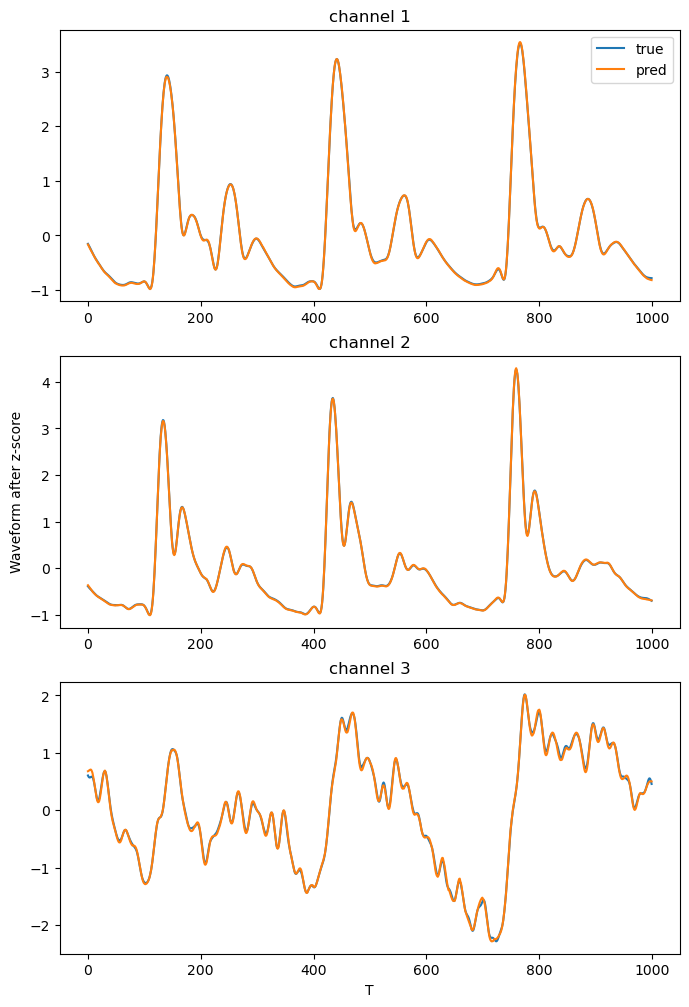

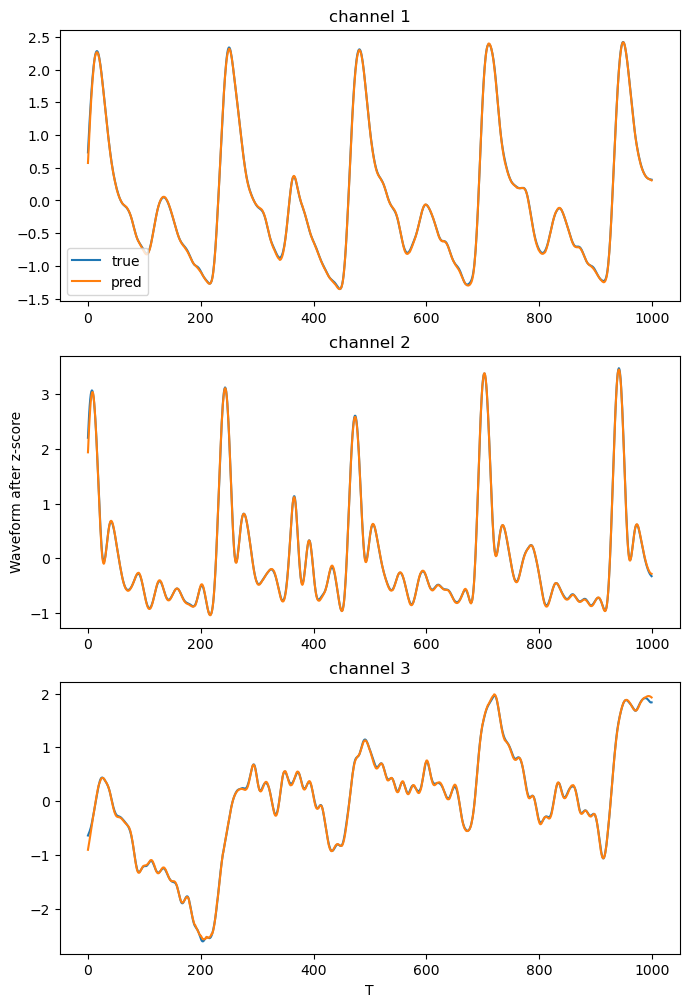

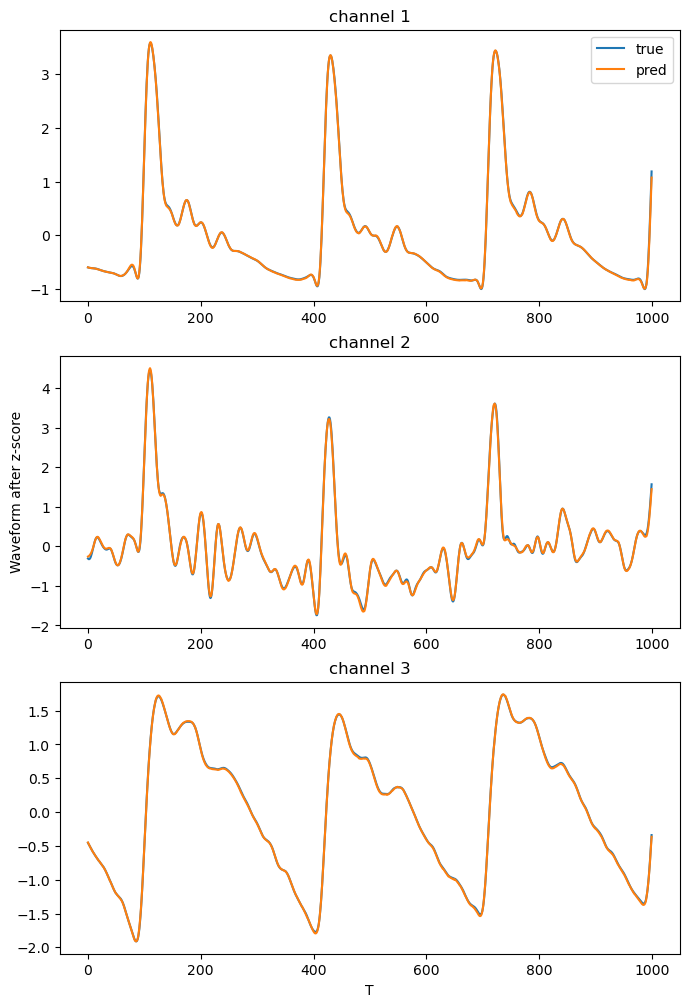

In [ ]:
batch = next(iter(datamodule.test_dataloader()))
batch = [item.to("cuda") for item in batch]
x, channel_idx, y = batch
x, y = model(x, channel_idx, mask=False, task="reconstruction")
for n in [0, 100, 200]:
    plt.figure(figsize=(8, 12))
    plt.subplot(3, 1, 1)
    plt.plot(y[n, 0].detach().cpu(), label="true")
    plt.plot(x[n, 0].detach().cpu(), label="pred")
    plt.title("channel 1")
    plt.legend()
    plt.subplot(3, 1, 2)
    plt.plot(y[n, 1].detach().cpu(), label="true")
    plt.plot(x[n, 1].detach().cpu(), label="pred")
    plt.title("channel 2")
    plt.ylabel("Waveform after z-score")
    plt.subplot(3, 1, 3)
    plt.plot(y[n, 2].detach().cpu(), label="true")
    plt.plot(x[n, 2].detach().cpu(), label="pred")
    plt.title("channel 3")
    plt.xlabel("T")
    plt.show()

### Finetune

In [7]:
# config
config_load_path = "config/finetune.json"
with open(config_load_path, "r") as f: config = json.load(f)
config["data"]["batch_size"] = 256
# datamodule
datamodule = src.data.DataModule(**config["data"])
datamodule.setup()
# model
ckpt = torch.load("ckpt/finetune/epoch=938-step=42255.ckpt", weights_only=True)
model = src.model.SCOST(**config["model"])
state_dict = {
    k.replace("model.", ""): v for k, v in ckpt["state_dict"].items()
    if k.startswith("model.")
}
model.load_state_dict(state_dict, strict=False)
model = model.to(device)
model.eval()

SCOST(
  (embedding): Embedding(
    (embd_token): EmbeddingToken(
      (te): Linear(in_features=20, out_features=256, bias=True)
    )
    (embd_channel): EmbeddingChannel(
      (ce): Embedding(8, 256)
    )
    (embd_position): EmbeddingPosition()
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
     

In [21]:
loss_train: torch.Tensor = None     # type: ignore
label_train: torch.Tensor = None    # type: ignore
for batch in datamodule.train_dataloader():
    with torch.no_grad():
        batch = [item.to(device) for item in batch]
        x, channel_idx, y = batch
        x, _ = model(x, channel_idx, mask=False, task="regression")
        loss_b = x - y
        if loss_train is None: loss_train = loss_b
        else: loss_train = torch.cat((loss_train, loss_b), dim=0)
        if label_train is None: label_train = y
        else: label_train = torch.cat((label_train, y), dim=0)
loss_val: torch.Tensor = None       # type: ignore
label_val: torch.Tensor = None      # type: ignore
for batch in datamodule.val_dataloader():
    with torch.no_grad():
        batch = [item.to(device) for item in batch]
        x, channel_idx, y = batch
        x, _ = model(x, channel_idx, mask=False, task="regression")
        loss_b = x - y
        if loss_val is None: loss_val = loss_b
        else: loss_val = torch.cat((loss_val, loss_b), dim=0)
        if label_val is None: label_val = y
        else: label_val = torch.cat((label_val, y), dim=0)
loss_test: torch.Tensor = None      # type: ignore
label_test: torch.Tensor = None      # type: ignore
for batch in datamodule.test_dataloader():
    with torch.no_grad():
        batch = [item.to(device) for item in batch]
        x, channel_idx, y = batch
        x, _ = model(x, channel_idx, mask=False, task="regression")
        loss_b = x - y
        if loss_test is None: loss_test = loss_b
        else: loss_test = torch.cat((loss_test, loss_b), dim=0)
        if label_test is None: label_test = y
        else: label_test = torch.cat((label_test, y), dim=0)

In [22]:
# calculate MAE and std
mae_train = torch.mean(torch.abs(loss_train), dim=0)
std_train = torch.std(torch.abs(loss_train), dim=0)
mae_val = torch.mean(torch.abs(loss_val), dim=0)
std_val = torch.std(torch.abs(loss_val), dim=0)
mae_test = torch.mean(torch.abs(loss_test), dim=0)
std_test = torch.std(torch.abs(loss_test), dim=0)
# print as a table, DBP and SBP
df = pd.DataFrame({
    "mae_train": mae_train.detach().cpu(),
    "std_train": std_train.detach().cpu(),
    "mae_val": mae_val.detach().cpu(),
    "std_val": std_val.detach().cpu(),
    "mae_test": mae_test.detach().cpu(),
    "std_test": std_test.detach().cpu(),
}, index=["DBP", "SBP"])
print(df.round(3))

     mae_train  std_train  mae_val  std_val  mae_test  std_test
DBP      1.176      1.072    2.613    2.629    21.361    15.992
SBP      0.981      0.777    1.967    1.765    15.667    13.006


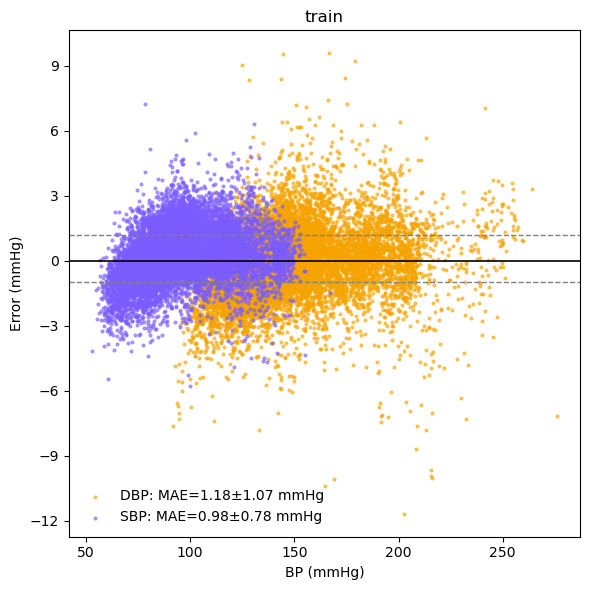

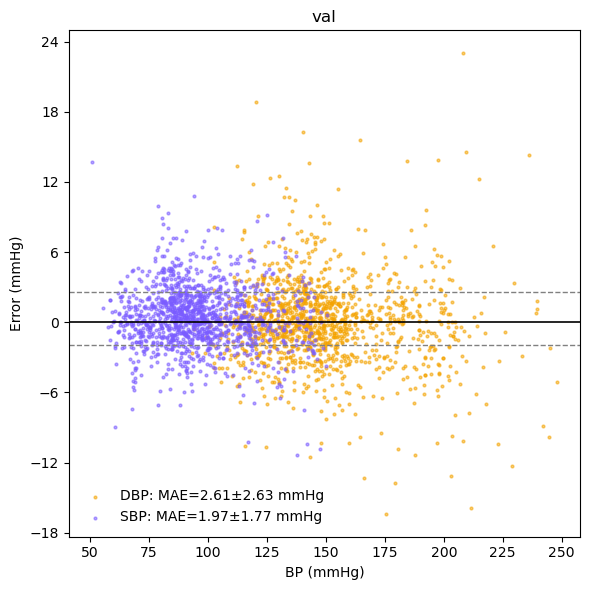

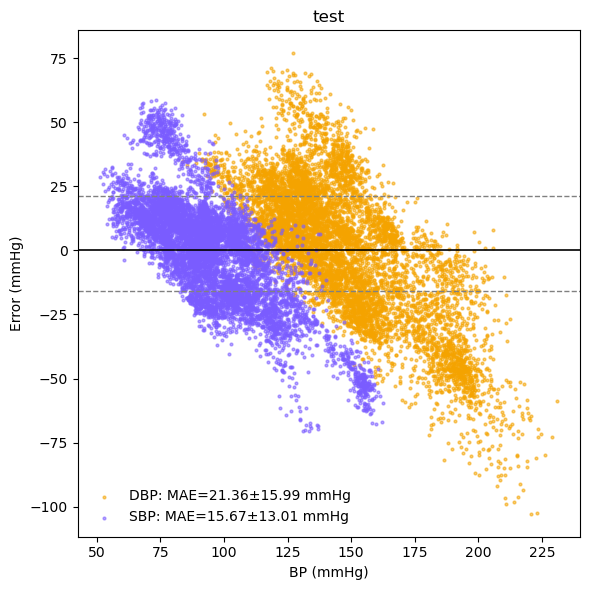

In [58]:
def plot_error_vs_mean(
    loss, label, title,
    labels=("DBP", "SBP"), colors=("#F4A300", "#7A5CFF"),
    s=4, alpha=0.55,
):
    # data
    loss = loss.detach().cpu()
    label = label.detach().cpu()
    mae = torch.mean(torch.abs(loss), dim=0)
    std = torch.std(torch.abs(loss), dim=0)
    # plot
    fig, ax = plt.subplots(figsize=(6, 6))
    for i in range(2):
        ax.scatter(
            label[:, i], loss[:, i], s=s, alpha=alpha, 
            color=colors[i], 
            label=f"{labels[i]}: MAE={mae[i]:.2f}±{std[i]:.2f} mmHg"
        )
    # Zero line and tolerance bands
    ax.axhline(0, color="black", linewidth=1.2)
    ax.axhline(+mae[0], color="gray", linestyle="--", linewidth=1)
    ax.axhline(-mae[1], color="gray", linestyle="--", linewidth=1)
    ax.set_xlabel("BP (mmHg)")
    ax.set_ylabel("Error (mmHg)")
    ax.set_title(title)
    ax.legend(frameon=False, loc="lower left")
    ax.yaxis.set_major_locator(ticker.MaxNLocator(8))
    plt.tight_layout()
    plt.show()

plot_error_vs_mean(loss_train, label_train, title="train")
plot_error_vs_mean(loss_val, label_val, title="val")
plot_error_vs_mean(loss_test, label_test, title="test")